In [1]:
from tqdm import tqdm
from glob import glob
from anomalib.engine import Engine
from anomalib import TaskType
from anomalib.models import Patchcore, Cflow,Cfa
from anomalib.utils.normalization import NormalizationMethod

In [2]:
# Import the datamodule
from anomalib.data import Folder
from anomalib.data.utils import TestSplitMode

# Create the datamodule
datamodule = Folder(
    name='dacon',
    root="dataset",
    normal_dir="train",
    abnormal_dir = 'test',
    test_split_mode=TestSplitMode.SYNTHETIC,
    task="classification",
    eval_batch_size = 1,
    seed = 0
)

In [3]:
model = Patchcore(
    backbone="wide_resnet101_2",
    pre_trained=True,
    coreset_sampling_ratio=0.1,
    layers=["layer2", "layer3"]    
)

In [4]:
engine = Engine(
    normalization=NormalizationMethod.MIN_MAX,
    task=TaskType.CLASSIFICATION,    
    accelerator="cuda",
    default_root_dir="./results/logs",    
    deterministic=True
)
engine.train(model=model, datamodule=datamodule)

c:\Users\lees\AppData\Local\anaconda3\envs\anomaly\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\lees\AppData\Local\anaconda3\envs\anomaly\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large da

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\lees\AppData\Local\anaconda3\envs\anomaly\lib\site-packages\lightning\pytorch\loops\optimization\automatic.py:129: `training_step` returned `None`. If this was on purpose, ignore this warning...


Validation: |          | 0/? [00:00<?, ?it/s]

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\lees\AppData\Local\anaconda3\envs\anomaly\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9586777091026306     │
│       image_F1Score       │    0.8148148059844971     │
└───────────────────────────┴───────────────────────────┘

In [5]:
# Import the datamodule
from anomalib.data import Folder
from anomalib.data.utils import TestSplitMode, ValSplitMode

# Create the datamodule
train = Folder(
    name='dacon',
    root="dataset",
    normal_dir="train",
    abnormal_dir = 'test',
    test_split_mode=TestSplitMode.FROM_DIR,
    val_split_mode=ValSplitMode.SAME_AS_TEST,
    task="classification",
    num_workers = 0,
    train_batch_size = 16,
    eval_batch_size = 1,
    test_split_ratio = 0.000001,
    seed = 0)

In [6]:
predictions = engine.predict(model=model,
                             datamodule= train,
                             ckpt_path='D:\\dacon\\ano\\results\\logs\\Patchcore\\dacon\\latest\\weights\\lightning\\model.ckpt')

c:\Users\lees\AppData\Local\anaconda3\envs\anomaly\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
('Zero subset length encountered during splitting. This means one of your subsets might be empty or devoid of either normal or anomalous images.',)
c:\Users\lees\AppData\Local\anaconda3\envs\anomaly\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
Restoring states from the checkpoint path at D:\dacon\ano\results\logs\Patchcore\dacon\v28\weights\lightning\model.ckpt
c:\Users\lees\AppData\Local\anaconda3\envs\anomaly\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targ

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
sub = []
for i in range(100):
    df = predictions[i]
    for img, preds in zip(df['image_path'], df['pred_scores']):
        sub.append(float(preds))

In [28]:
import pandas as pd
submission = pd.read_csv('sample_submission.csv')

In [ ]:
submission['label'] = sub

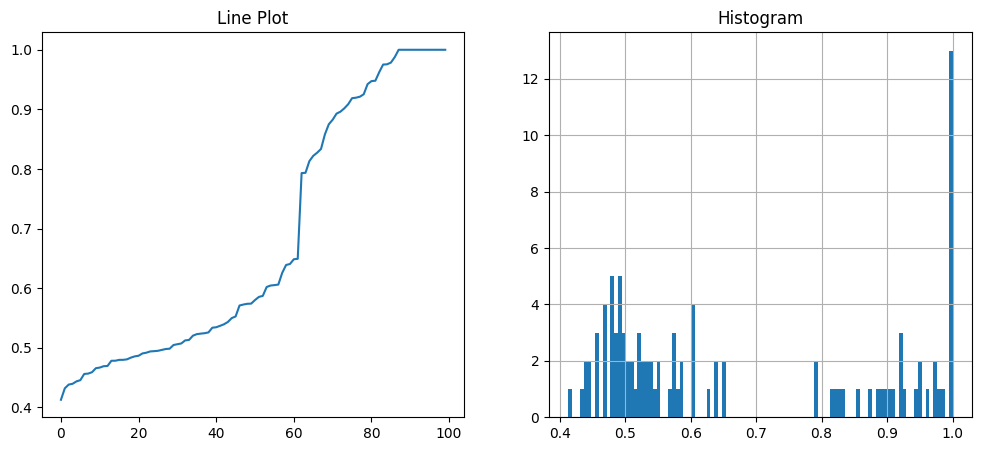

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

submission.label.sort_values().reset_index(drop=True).plot(ax=ax[0])
ax[0].set_title('Line Plot')

submission.label.hist(bins=100, ax=ax[1])
ax[1].set_title('Histogram')

plt.show()

In [35]:
submission['label'] = submission.label.apply(lambda x:0 if x<0.7 else 1)

In [42]:
submission.to_csv('submission.csv',index=False)